In [ ]:
import os #module to get the list of files in the directory for taking the dataset 
from concurrent.futures import as_completed, ThreadPoolExecutor
import cv2 #module to read the images
import matplotlib.pyplot as plt #for plotting graphs
import numpy as np #module to perform numerical operations
import pandas as pd  #for DataFrames and Series
import seaborn as sns # data visualization
from scipy import fft #for Fast Fourier Transform
from sklearn.model_selection import train_test_split #for splitting the dataset into training and testing 
from sklearn.linear_model import LinearRegression #for performing linear regression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score # for model evaluation metrics
from sklearn.cluster import KMeans  # for performing K-Means clustering
from sklearn.metrics import silhouette_score # for evaluating clustering performance using silhouette score
from sklearn.metrics import calinski_harabasz_score # for evaluating clustering using Calinski-Harabasz index
from sklearn.metrics import davies_bouldin_score  # for evaluating clustering using Davies-Bouldin index

In [1]:
def to_gray(image): #function to convert the image to grayscale
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def load_img_with_features(filepath): 
    img = cv2.imread(filepath)# Load the image from the specified file path
    gray_img = to_gray(img)# Convert the image to grayscale
    features = np.abs(fft.fft2(gray_img)).flatten()# Extract features from the grayscale image
    # Return the list of means, list of variances, and the corresponding label
    return features[0], features[1:], features


def load_imgs_from_directory(directory, num_images=None):
    dc_val = []
    dc_dash_val = []
    features_1 = []
    files = os.listdir(directory)# Get the list of all files in the specified directory
    # Limit the number of files to the specified number if provided
    if num_images is not None: 
        files = files[:num_images]
    with ThreadPoolExecutor() as executor:# Use ThreadPoolExecutor to process images concurrently
        # Submit tasks to executor for loading images and extracting features
        futures = [executor.submit(load_img_with_features, os.path.join(directory, filename)) for filename in files]
        # Process each future as it completes
        for future in as_completed(futures):
            dc, dc_dash, features = future.result()
            features_1.append(features)
            dc_val.append(dc)
            dc_dash_val.append(dc_dash)
    # Return lists of DC values, DC dash values, and extracted features
    return dc_val, dc_dash_val, features_1



fake_dir='E:\zipp\college\Third Year\\5th Sem\ML\ML\Lab 3\\train\FAKE' #Fake Images
real_dir='E:\zipp\college\Third Year\\5th Sem\ML\ML\Lab 3\\train\REAL' #Real Images


C:\Users\soumi\AppData\Local\Temp\ipykernel_6560\3557775069.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
num_images_to_load = 10000 #Number of images to load

# Load images from the fake directory and extract DC values, DC dash values, and features
DC_vals_train, DC_dash_train, features_fake = load_imgs_from_directory(fake_dir, num_images=num_images_to_load)
# Load images from the real directory and extract DC values, DC dash values, and features
DC_vals_test, DC_dash_test, features_real = load_imgs_from_directory(real_dir, num_images=num_images_to_load)

dc_val = np.concatenate((DC_vals_test, DC_vals_train))# Concatenate DC values from both the test and train datasets
dc_dash= np.vstack((DC_dash_test, DC_dash_train))# Stack DC dash values vertically from both datasets
features = np.vstack((features_fake, features_real))# Stack feature arrays vertically from both the fake and real datasets


In [3]:
#Splitting the dataset into training and testing sets, 50 percent of data will be used for testing.
X_train, X_test, y_train, y_test = train_test_split(dc_dash, dc_val, test_size=0.5, random_state=32)

In [5]:
reg = LinearRegression().fit(X_train, y_train)# Create and train a Linear Regression model using the training data
# Predict the target values (DC values) for the test dataset using the trained model
y_train_pred = reg.predict(X_test)

In [7]:
print(y_train_pred)
print(y_train)

[103721.2306 122555.2306 128509.2306 ... 121093.2306 106982.2306
 126485.2306]
[141127. 107585. 104446. ... 155980. 119368. 126529.]


In [8]:
# Calculate Mean Squared Error (MSE) between actual and predicted values on the test data
mse_train = mean_squared_error(y_train, y_train_pred)
# Calculate Root Mean Squared Error (RMSE) on the test data
rmse_train = np.sqrt(mse_train)
# Calculate Mean Absolute Percentage Error (MAPE) between actual and predicted values on the test data
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
# Calculate R^2 Score (coefficient of determination) to evaluate the goodness of fit
r2_train = r2_score(y_train, y_train_pred)

print(f"Mean Squared Error (MSE) on training data:\t{mse_train}")
print(f"Root Mean Squared Error (RMSE) on training data:\t{rmse_train}")
print(f"Mean Absolute Percentage Error (MAPE) on training data:\t{mape_train}")
print(f"R^2 Score on training data:\t{r2_train}")

Mean Squared Error (MSE) on training data:	868059841.4117482
Root Mean Squared Error (RMSE) on training data:	29462.85528274115
Mean Absolute Percentage Error (MAPE) on training data:	0.20882360934853314
R^2 Score on training data:	-0.13437341776656275


In [10]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(features)
print(kmeans.labels_)#print the labels assigned to each sample
print(kmeans.cluster_centers_)# Print the coordinates of the cluster centers
calinski_harabasz_score(features, kmeans.labels_)# Compute the Calinski-Harabasz score to evaluate the clustering quality

[0 0 1 ... 1 1 0]
[[101644.45603814   9971.24047836   5271.42107021 ...   2808.60174411
    3997.06992778   6819.65803537]
 [144889.09432657  10115.81805014   5291.58928044 ...   2748.75129843
    4014.48328052   6951.77941988]]


7863.660641600254

In [11]:
def kmeans_wrapper(n_clusters, X):
    kmeans = KMeans(n_clusters=n_clusters, random_state=32).fit(X)
    print(kmeans.labels_)#print the labels assigned to each sample
    return {
        "labels": kmeans.labels_,
        "centres": kmeans.cluster_centers_,
        "inertia": kmeans.inertia_,
    }

In [12]:
def get_scores(X, start, end):
    # Initialize a dictionary to store clustering scores and distortions for different numbers of clusters
    results = {
        "Davies-Bouldin Score": [],# To store Davies-Bouldin scores
        "Silhouette Score": [],# To store Silhouette scores
        "Calinski-Harabasz Score": [],# To store Calinski-Harabasz scores
        "distortions": [], # To store inertia (within-cluster sum of squares)
        "K": list(range(start, end)) # Range of cluster numbers to evaluate
    }
    # Loop over the range of cluster numbers
    for i in range(start, end):
        # Get the clustering results for the current number of clusters
        labels, centres, inertia = kmeans_wrapper(i, X).values()
        n_labels = len(set(labels)) # Number of unique clusters

        # Calculate the scores only if more than one cluster is formed
        if n_labels > 1:  # Proceed only if there is more than one cluster
            results["Calinski-Harabasz Score"].append(calinski_harabasz_score(X, labels))# Append the Calinski-Harabasz score for current clustering
            results["Silhouette Score"].append(silhouette_score(X, labels))# Append the Silhouette score for current clustering
            results["Davies-Bouldin Score"].append(davies_bouldin_score(X, labels))# Append the Davies-Bouldin score for current clustering
        results["distortions"].append(inertia)# Append the distortion (inertia) for current clustering
    return results# Return the dictionary containing all scores and distortions

In [13]:
features

array([[ 98735.        ,   7723.86140451,   7013.4052213 , ...,
          1924.50168508,   1940.75781431,   9461.6612842 ],
       [106979.        ,   3892.20315557,   3644.34430744, ...,
          4524.1444969 ,   5072.40688809,   8376.08616131],
       [128394.        ,   6061.97285841,   2575.8619036 , ...,
          2410.49730847,   4176.25583801,   4875.33641726],
       ...,
       [167738.        ,   8304.27830827,   3693.27266513, ...,
          5250.026441  ,   4124.60159029,   3390.18982707],
       [180160.        ,  17826.39983097,   3579.48406243, ...,
          3768.37741727,   5550.39950522,  14511.02408039],
       [ 77181.        ,   2870.65557877,   3171.85725784, ...,
          1823.95496442,   6630.43065552,  12190.31032044]])

In [14]:
results_df = pd.DataFrame(get_scores(features, 2, 25)) 

[1 1 0 ... 0 0 1]
[1 1 2 ... 0 0 1]
[3 2 2 ... 0 0 3]
[3 3 0 ... 4 4 3]
[1 1 0 ... 5 5 3]
[1 6 0 ... 5 5 3]
[6 0 0 ... 4 4 3]
[6 0 5 ... 4 4 3]
[6 0 0 ... 5 4 9]
[6 0 0 ... 5 4 9]
[6 0 8 ... 5 4 9]
[ 6  0  5 ...  4 12  9]
[ 6 13  0 ...  4 12  9]
[14  6  8 ...  4  4  9]
[14  6  0 ...  4  4  9]
[14  6  0 ...  5  4  9]
[14 17  8 ...  4  4 14]
[14 17  0 ...  4  4 14]
[19 17  0 ...  5  4 19]
[10 13 11 ... 12 12 19]
[10 13 11 ... 12 12 19]
[10 11  0 ...  7 12 19]
[10 15  0 ... 12 12 19]


In [16]:
results_df

,Davies-Bouldin Score,Silhouette Score,Calinski-Harabasz Score,distortions,K
0,1.524056,0.232164,7863.661765,2.380523e+13,2
1,1.783593,0.160861,5859.163327,2.091166e+13,3
2,1.968960,0.143184,4744.820234,1.937417e+13,4
3,1.886926,0.144993,4159.959259,1.810172e+13,5
4,1.907750,0.113106,3715.335621,1.719235e+13,6
5,1.931492,0.109915,3359.919038,1.651422e+13,7
6,1.985544,0.104917,3053.889065,1.602772e+13,8
7,2.001161,0.090195,2817.625362,1.558876e+13,9
8,2.122601,0.089003,2593.052355,1.530179e+13,10
9,2.067341,0.088194,2432.518685,1.496033e+13,11


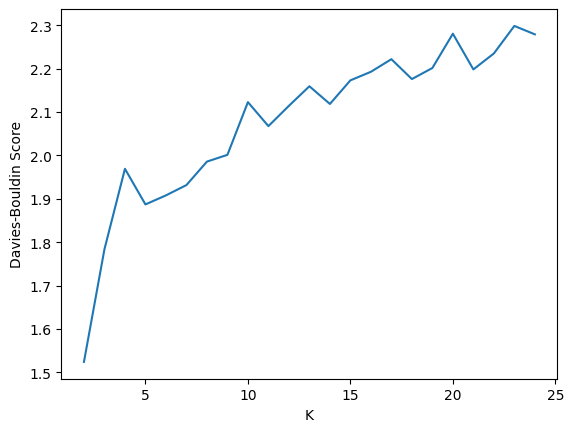

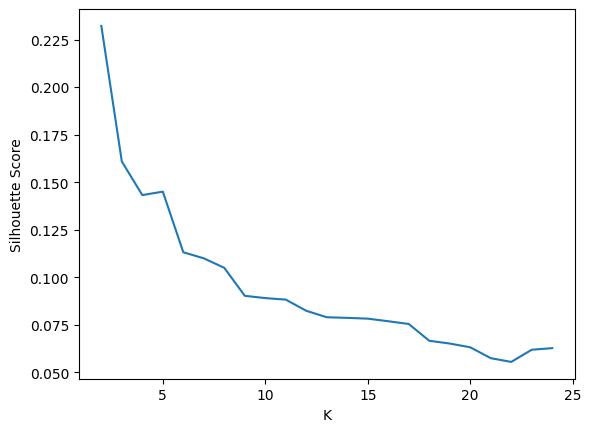

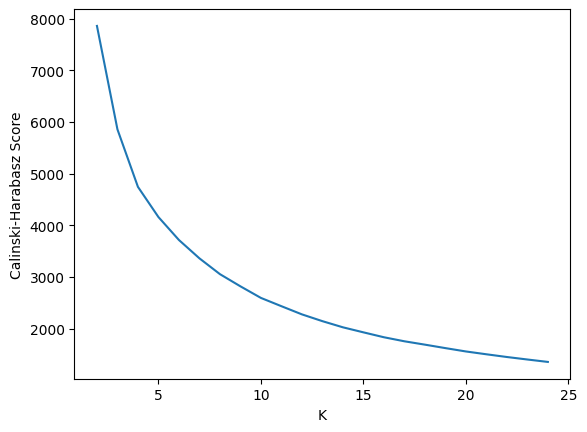

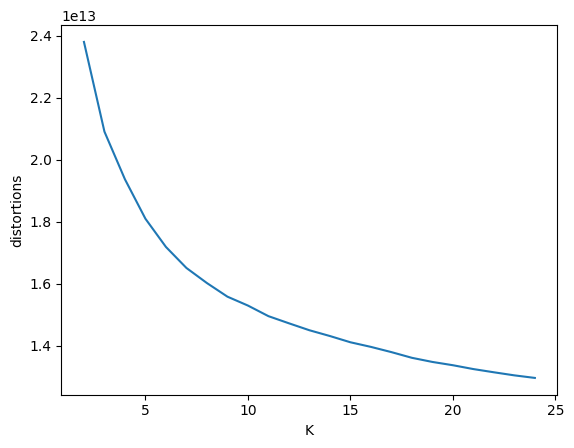

In [17]:
sns.lineplot(data = results_df, x="K", y="Davies-Bouldin Score")
plt.show()
sns.lineplot(data=results_df, x="K", y="Silhouette Score")
plt.show()
sns.lineplot(data=results_df, x="K", y="Calinski-Harabasz Score")
plt.show()
sns.lineplot(data=results_df, x="K", y="distortions")
plt.show()